IMPORTS 

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input as densenet_pre
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_pre
from tensorflow.keras.applications.resnet import preprocess_input as resnet_pre
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

LOAD THE TRAINED MODELS 

In [2]:
densenet_model = load_model("densenet201_finetuned_model.h5", compile=False)
vgg_model      = load_model("vgg16_finetuned_model.h5", compile=False)
resnet_model   = load_model("resnet50_finetuned_model.h5", compile=False)

models = [
    (densenet_model, densenet_pre, "DenseNet201"),
    (vgg_model, vgg_pre, "VGG16"),
    (resnet_model, resnet_pre, "ResNet50")
]

BINARY CLASS MAPPING FUNCTION

In [3]:
venomous_classes = ["barredcoral snake", "king cobra", "north ph temple pitviper"]

def csv_to_binary_labels(csv_path, image_dir):
    df = pd.read_csv(csv_path)
    class_cols = df.columns[1:]  # skip filename
    df["label"] = df[class_cols].idxmax(axis=1)
    df["binary_label"] = df["label"].apply(lambda x: 1 if x in venomous_classes else 0)

    df_binary = df[["filename", "binary_label"]].copy()
    df_binary["filename"] = df_binary["filename"].apply(lambda x: f"{image_dir}/{x}")
    df_binary["binary_label"] = df_binary["binary_label"].astype(str)
    return df_binary

DATAFRAME GENERATORS 

In [4]:
datagen = ImageDataGenerator()

val_df  = csv_to_binary_labels("../dataset/valid/_classes.csv", "../dataset/valid")
test_df = csv_to_binary_labels("../dataset/test/_classes.csv", "../dataset/test")

val_generator = datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="binary_label",
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary",
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="binary_label",
    target_size=(224, 224),
    batch_size=16,
    class_mode="binary",
    shuffle=False
)

Found 1800 validated image filenames belonging to 2 classes.
Found 900 validated image filenames belonging to 2 classes.


PREDICTION WITH PREPROCESSING

In [5]:
def predict_with_preprocess(model, generator, preprocess_fn):
    X_batches = []
    for batch, _ in generator:
        X_batches.append(preprocess_fn(batch.copy()))
        if len(X_batches) * generator.batch_size >= len(generator.filenames):
            break
    X = np.concatenate(X_batches)
    return model.predict(X, verbose=0).flatten()

COLLECT PREDICTIONS

In [6]:
def get_all_preds(models, generator):
    preds = []
    for model, preprocess_fn, name in models:
        generator.reset()
        p = predict_with_preprocess(model, generator, preprocess_fn)
        preds.append(p)
        print(f"{name} predictions done, shape: {p.shape}")
    return np.array(preds)  # shape: (n_models, n_samples)

val_preds  = get_all_preds(models, val_generator)
test_preds = get_all_preds(models, test_generator)

y_val  = val_df["binary_label"].astype(int).values
y_test = test_df["binary_label"].astype(int).values

DenseNet201 predictions done, shape: (1800,)
VGG16 predictions done, shape: (1800,)
ResNet50 predictions done, shape: (1800,)
DenseNet201 predictions done, shape: (900,)
VGG16 predictions done, shape: (900,)
ResNet50 predictions done, shape: (900,)


STACKING ENSEMBLE FUNCTION

In [7]:
def stacking_ensemble(val_preds, y_val, test_preds, y_test):
    # reshape predictions: (n_models, n_samples) -> (n_samples, n_models)
    X_val  = val_preds.T  
    X_test = test_preds.T

    # Logistic Regression as meta-learner
    meta = LogisticRegression(max_iter=1000, class_weight="balanced")
    meta.fit(X_val, y_val)

    meta_probs = meta.predict_proba(X_test)[:, 1]
    meta_preds = (meta_probs > 0.5).astype(int)

    acc = accuracy_score(y_test, meta_preds)
    prec = precision_score(y_test, meta_preds, zero_division=0)
    rec = recall_score(y_test, meta_preds, zero_division=0)
    f1 = f1_score(y_test, meta_preds, zero_division=0)

    return (acc, prec, rec, f1), meta_preds

stack_metrics, stack_preds = stacking_ensemble(val_preds, y_val, test_preds, y_test)

STACKED ENSEMBLE CONFUSION MATRIX

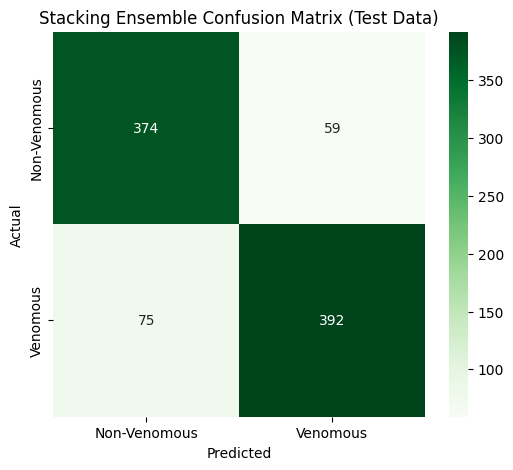

In [8]:
cm_stack = confusion_matrix(y_test, stack_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Non-Venomous", "Venomous"],
            yticklabels=["Non-Venomous", "Venomous"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Stacking Ensemble Confusion Matrix (Test Data)")
plt.show()

STACKED ENSEMBLE METRICS

In [9]:
print("\nStacking Ensemble (Logistic Regression) on Test:")
print("Accuracy:  {:.2f}%".format(stack_metrics[0] * 100))
print("Precision: {:.2f}%".format(stack_metrics[1] * 100))
print("Recall:    {:.2f}%".format(stack_metrics[2] * 100))
print("F1 Score:  {:.2f}%".format(stack_metrics[3] * 100))


Stacking Ensemble (Logistic Regression) on Test:
Accuracy:  85.11%
Precision: 86.92%
Recall:    83.94%
F1 Score:  85.40%
